In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as pyplot
import torchvision.models as models

In [15]:
from PIL import Image
from pathlib import Path
from typing import Tuple
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
test_data_path = Path("/content/drive/MyDrive/Dataset/Testing")
train_data_path = Path("/content/drive/MyDrive/Dataset/Training")
model_path = Path("/content/drive/MyDrive/Models/vgg19_transfer.pth")

In [6]:
image_transform = transforms.Compose(
    [
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.1855, 0.1855, 0.1855], std=[0.2003, 0.2003, 0.2004]
        ),
    ]
)

In [7]:
train_data = ImageFolder(train_data_path, transform=image_transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

test_data = ImageFolder(test_data_path, transform=image_transform)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [8]:
NUM_CLASSES = len(train_data.classes)

In [9]:
class VGG19(nn.Module):
    def __init__(self, original_vgg19_model):
        super(VGG19, self).__init__()

        self.original_vgg19_model = original_vgg19_model
        self.features = self.original_vgg19_model.features
        self.classifier = self.original_vgg19_model.classifier
        self.switch_indices = [0] * len(self.features)

        for layer in self.features:
            if isinstance(layer, nn.MaxPool2d):
                layer.return_indices = True
            if isinstance(layer, nn.ReLU):
                layer.inplace = True

        in_features = self.classifier[-1].in_features
        final_classifier_layer = len(self.classifier) - 1

        self.classifier[final_classifier_layer] = nn.Linear(4096, NUM_CLASSES)

    def forward(self, batch: torch.Tensor):
        for i, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                batch, indices = layer(batch)
                self.switch_indices[i] = indices
            else:
                batch = layer(batch)

        batch = batch.view(batch.size(0), -1)
        batch_probabilities = self.classifier(batch)

        return batch_probabilities

In [10]:
original_vgg19_model = models.vgg19(weights="VGG19_Weights.DEFAULT")
vgg19 = VGG19(original_vgg19_model).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 60.4MB/s]


In [11]:
def train_model(model, num_epochs, train_loader, optimizer, loss_fn):
    for epoch in range(num_epochs):
        model.train()

        correct_predictions = 0
        total_samples = 0

        for _, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            batch_probabilities = model(images)
            loss = loss_fn(batch_probabilities, labels)
            loss.backward()

            optimizer.step()

            _, predicted_labels = torch.max(batch_probabilities, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += predicted_labels.size(0)

        train_accuracy = correct_predictions / total_samples
        print(f"Epoch: {epoch + 1} Train accuracy: {train_accuracy}")

In [16]:
@torch.no_grad()
def test_model(model, test_loader):
    model.eval()

    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_predictions = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_samples
    print(f"Accuracy: {accuracy:.2%}")

    cm = confusion_matrix(all_labels, all_predictions)
    ConfusionMatrixDisplay(cm).plot()

In [13]:
train_model(vgg19, 10, train_loader, optimizer, loss_fn)

Epoch: 1 Train accuracy: 0.7993697478991597
Epoch: 2 Train accuracy: 0.9089635854341737
Epoch: 3 Train accuracy: 0.9389005602240896
Epoch: 4 Train accuracy: 0.9548319327731093
Epoch: 5 Train accuracy: 0.9698879551820728
Epoch: 6 Train accuracy: 0.9784663865546218
Epoch: 7 Train accuracy: 0.9840686274509803
Epoch: 8 Train accuracy: 0.9903711484593838
Epoch: 9 Train accuracy: 0.9921218487394958
Epoch: 10 Train accuracy: 0.9938725490196079


Accuracy: 97.73%


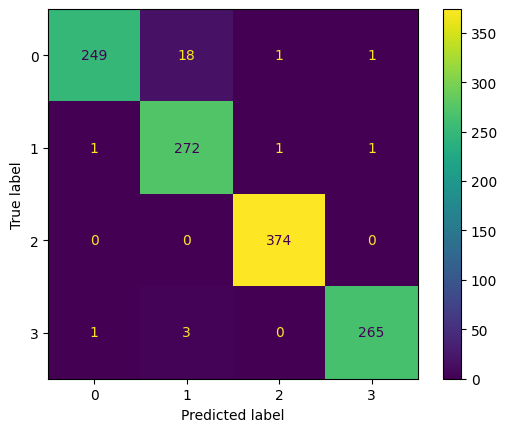

In [17]:
test_model(vgg19, test_loader)

In [18]:
torch.save(vgg19.state_dict(), model_path)